In [1]:
# fit generated data

In [2]:
from matplotlib.pyplot import *
import numpy as np
import pandas as pd
import os
import importlib


from ATARI.sammy_interface import sammy_interface, sammy_classes, sammy_functions, template_creator
from ATARI.utils.misc import fine_egrid

from ATARI.ModelData.particle_pair import Particle_Pair
from ATARI.ModelData.experimental_model import Experimental_Model
from ATARI.ModelData.measurement_models import transmission_rpi, capture_yield_rpi

from copy import copy

from ATARI.AutoFit import chi2_eliminator_v2
from ATARI.AutoFit import elim_addit_funcs

In [3]:
%matplotlib widget

In [4]:
current_dir = './'

settings = {
    'path_to_SAMMY_exe': '/home/fire/SAMMY/sammy/build/install/bin/sammy',
    'path_to_SAMMY_temps': os.path.join(current_dir, 'sammy_temps/'), # relative to current directory!
    'keep_runDIR_SAMMY': True,
    'shell_SAMMY': 'bash',
    'running_path': current_dir
}

# for one case - fit this id
case_id = 3

fig_size_data = (8,6)
fig_size_SF_xs = (8,6)

showfigures = False # show figures and block script execution


In [5]:
# load the generated data

cases_folder_name = 'syn_data/'
cases_folder_name = 'syn_data_1/'
cases_folder_name = 'syn_data_2/'
cases_folder_name = 'syn_data_5/'
cases_folder_name = 'syn_data_4/'
#cases_folder_name = 'syn_data_6/'
cases_folder_name = 'syn_data_0/'

fit_res_folder = cases_folder_name+'fit_res/'

case_filename = f'sample_{case_id}.pkl'
gen_params_filename =  f'params_gen.pkl'

sample_data = elim_addit_funcs.load_obj_from_pkl(folder_name = cases_folder_name,
                                                     pkl_fname = case_filename )

params_loaded = elim_addit_funcs.load_obj_from_pkl(folder_name = cases_folder_name,
                                                     pkl_fname= gen_params_filename)

In [6]:
# Usage
filename_pattern = 'sample_*.pkl'

filenames, cases_ids = elim_addit_funcs.get_filenames_and_cases_ids(cases_folder_name, filename_pattern)
print("Filenames:", filenames)
print("cases ids:", cases_ids)
print(len(cases_ids))

Filenames: ['sample_0.pkl', 'sample_1.pkl', 'sample_2.pkl', 'sample_3.pkl', 'sample_4.pkl', 'sample_5.pkl', 'sample_6.pkl', 'sample_7.pkl', 'sample_8.pkl', 'sample_9.pkl', 'sample_10.pkl', 'sample_11.pkl', 'sample_12.pkl', 'sample_13.pkl', 'sample_14.pkl', 'sample_15.pkl', 'sample_16.pkl', 'sample_17.pkl', 'sample_18.pkl', 'sample_19.pkl', 'sample_20.pkl', 'sample_21.pkl', 'sample_22.pkl', 'sample_23.pkl', 'sample_24.pkl', 'sample_25.pkl', 'sample_26.pkl', 'sample_27.pkl', 'sample_28.pkl', 'sample_29.pkl', 'sample_30.pkl', 'sample_31.pkl', 'sample_32.pkl', 'sample_33.pkl', 'sample_34.pkl', 'sample_35.pkl', 'sample_36.pkl', 'sample_37.pkl', 'sample_38.pkl', 'sample_39.pkl', 'sample_40.pkl', 'sample_41.pkl', 'sample_42.pkl', 'sample_43.pkl', 'sample_44.pkl', 'sample_45.pkl', 'sample_46.pkl', 'sample_47.pkl', 'sample_48.pkl', 'sample_49.pkl', 'sample_50.pkl', 'sample_51.pkl', 'sample_52.pkl', 'sample_53.pkl', 'sample_54.pkl', 'sample_55.pkl', 'sample_56.pkl', 'sample_57.pkl', 'sample_58.p

In [7]:
# # data
# print(sample_data['trans1mm'].pw_reduced)
# print(type(sample_data['trans1mm'].par_true))
# print(sample_data['trans1mm'].par_true)
# print()

# print('Params loaded:')

#Ta_pair
syndat_loaded = params_loaded #['syndat_control']
Ta_pair_loaded = syndat_loaded.particle_pair

print(Ta_pair_loaded.spin_groups)

# energy range
print(f'energy range extracted from model: {syndat_loaded.syndat_models[0].generative_experimental_model.energy_range}')
print(f'Energy range used in Ta_pair: {Ta_pair_loaded.total_energy_range}')

{'3.0': {'J_ID': 1, '<D>': 8.79, '<Gn>': 46.5, 'n_dof': 1, '<Gg>': 64.0, 'g_dof': 1000, 'D01': 0.9943384234177864, 'D99': 21.284662911191237, 'Gn01': 0.007304585392801135, 'Gn99': 308.52269194748646, 'Gg01': 57.53039660349525, 'Gg99': 70.84601563854191, 'Gt01': 57.53770118888805, 'Gt99': 379.3687075860284}, '4.0': {'J_ID': 2, '<D>': 4.99, '<Gn>': 35.5, 'n_dof': 1, '<Gg>': 64.0, 'g_dof': 1000, 'D01': 0.5644765338856377, 'D99': 12.083102153224605, 'Gn01': 0.005576618955794415, 'Gn99': 235.53882933625312, 'Gg01': 57.53039660349525, 'Gg99': 70.84601563854191, 'Gt01': 57.53597322245104, 'Gt99': 306.38484497479504}}
energy range extracted from model: [202.0369812628, 226.9092922115]
Energy range used in Ta_pair: [202, 227]


In [8]:
# a try to fit simply using YW scheme

# combining all the data into appropriate list
sample_datasets = []
sample_experiments = []
sample_covariance_data = []

Ta_pair_loaded = syndat_loaded.particle_pair

for index, el in enumerate(syndat_loaded.syndat_models):
    print(index)
    print(el.title)
    
    current_key = list(sample_data)[index] 
    
    #print(type(el.generative_experimental_model))
    #print(el.generative_experimental_model)

    sample_datasets.append(sample_data[current_key].pw_reduced)
    sample_experiments.append(el.generative_experimental_model)
    
    print(f'Energy range: {el.generative_experimental_model.energy_range}')

    sample_cov_data = sample_data[current_key].covariance_data

    sample_covariance_data.append(sample_cov_data)

    # TODO: how to check covariance data?
    #print(sample_data[current_key].covariance_data)
    for key, val in sample_cov_data.items():
        
        print(key)
        print(type(val))
        print(val.shape)

        if isinstance(val, pd.DataFrame):  # Checks if val is a DataFrame
            print(val.dtypes)  # This will print the data types of all columns in the DataFrame
        else:
            pass
        
        #print(val)  # This will print each key followed by its corresponding value

        # # reconstruct full cov matrix
        # full_cov = sample_cov_data['Jac_sys'] @ sample_cov_data['Cov_sys'] @ sample_cov_data['Jac_sys'].T + sample_cov_data['diag_stat']
        # print(full_cov)
        




# print('Datasets')
# print(sample_datasets)
# print('Exp models:')
# print(sample_experiments)
# print('Covariance data')
# print(sample_covariance_data)


# dataset size
sum_points = 0 
print(f'Dataset sizes: {len(sample_datasets)}')

for index,el in enumerate(sample_datasets):
    sum_points += el.shape[0]
    print(f'{sample_experiments[index].title} - {el.shape[0]}')

print(f'Num of points: {sum_points}')

0
trans1mm
Energy range: [202.0369812628, 226.9092922115]
Cov_sys
<class 'numpy.ndarray'>
(10, 10)
Jac_sys
<class 'pandas.core.frame.DataFrame'>
(10, 199)
E
202.036981    float64
202.199565    float64
202.362345    float64
202.525321    float64
202.688494    float64
               ...   
226.522995    float64
226.619477    float64
226.716020    float64
226.812625    float64
226.909292    float64
Length: 199, dtype: object
diag_stat
<class 'pandas.core.frame.DataFrame'>
(199, 1)
var_stat    float64
dtype: object
1
trans3mm
Energy range: [202.0369812628, 226.9092922115]
Cov_sys
<class 'numpy.ndarray'>
(10, 10)
Jac_sys
<class 'pandas.core.frame.DataFrame'>
(10, 199)
E
202.036981    float64
202.199565    float64
202.362345    float64
202.525321    float64
202.688494    float64
               ...   
226.522995    float64
226.619477    float64
226.716020    float64
226.812625    float64
226.909292    float64
Length: 199, dtype: object
diag_stat
<class 'pandas.core.frame.DataFrame'>
(199, 1)


In [9]:
# setting the initial guess ladder: 

ig_ladder = sample_data['trans1mm'].par_true.copy()

ig_ladder = elim_addit_funcs.make_ladder_correct_types(ladder_df=ig_ladder)

ig_ladder = elim_addit_funcs.set_varying_fixed_params(ladder_df=ig_ladder,
                                                      vary_list=[1,1,1])

# enrich dataframe with the u-params
ig_ladder = elim_addit_funcs.update_u_by_p(ladder_full = ig_ladder, 
                                            Ta_pair = Ta_pair_loaded)

print('Initial guess ladder:')
print(ig_ladder)

Initial guess ladder:
            E         Gg         Gn1    J  J_ID  varyE  varyGg  varyGn1  \
0  203.136619  59.711558    3.165653  3.0   1.0      1       1        1   
1  216.170106  63.605709   25.448985  3.0   1.0      1       1        1   
2  226.112816  63.382691   55.243136  3.0   1.0      1       1        1   
3  203.237565  63.841719    3.505922  4.0   2.0      1       1        1   
4  207.845875  62.675050  117.435403  4.0   2.0      1       1        1   
5  209.757033  65.251392   17.385747  4.0   2.0      1       1        1   
6  215.394370  63.136644   18.482512  4.0   2.0      1       1        1   
7  222.570229  58.246294   16.476618  4.0   2.0      1       1        1   

         u_e       u_g      u_n1  
0  14.252600  0.172788  0.079087  
1  14.702724  0.178334  0.220777  
2  15.037048  0.178021  0.321644  
3  14.256141  0.178664  0.083218  
4  14.416861  0.177024  0.478941  
5  14.482991  0.180626  0.183859  
6  14.676320  0.177675  0.188317  
7  14.918788  0.170655

In [10]:
fit_rto = sammy_classes.SammyRunTimeOptions(
    sammyexe = settings['path_to_SAMMY_exe'],
    options = {"Print"   :   True,
                "bayes"   :   True,
                "keep_runDIR"     : True,
                "sammy_runDIR": elim_addit_funcs.generate_sammy_rundir_uniq_name(path_to_sammy_temps = settings['path_to_SAMMY_temps'])
                })


fit_sammyINPyw = sammy_classes.SammyInputDataYW(
    particle_pair = Ta_pair_loaded,
    resonance_ladder = ig_ladder,

    datasets = sample_datasets,
    experiments = sample_experiments,
    experimental_covariance = sample_covariance_data,
        
    max_steps = 10,
    iterations = 2,
    step_threshold = 0.01,
    autoelim_threshold = None,

    LS = False,
    LevMar = True,
    LevMarV = 2,
    LevMarVd= 5,
    initial_parameter_uncertainty = 0.1
    )

sammyOUT_YW = sammy_functions.run_sammy_YW(fit_sammyINPyw, fit_rto)

Stepping until convergence
chi2 values
step fudge: ['trans1mm', 'trans3mm', 'trans6mm', 'cap1mm', 'cap2mm', 'sum', 'sum/ndat']
0    0.1  : [3189.25, 3538.08, 4807.68, 382.609, 303.514, 12221.133, 14.3947]
1    0.2  : [3209.77, 3506.76, 4506.88, 382.983, 316.372, 11922.765, 14.0433]
2    0.4  : [3215.49, 3508.2, 4483.19, 384.66, 321.905, 11913.445, 14.0323]
Repeat step 3, 	fudge: ['trans1mm', 'trans3mm', 'trans6mm', 'cap1mm', 'cap2mm', 'sum', 'sum/ndat']
		0.08 : [3216.12, 3508.71, 4481.6, 384.879, 320.914, 11912.223, 14.0309]
3    0.08 : [3216.12, 3508.71, 4481.6, 384.879, 320.914, 11912.223, 14.0309]
Chi2 improvement below threshold


In [ ]:
# sammyOUT_YW 

In [11]:
elim_addit_funcs.printout_chi2(sammyOUT=sammyOUT_YW)

Solution chi2 values
N_Dat: 849
Chi2:
	 Prior:
		 [3189.25, 3538.08, 4807.68, 382.609, 303.514] 12221.133
	 Posterior:
		 [3216.12, 3508.71, 4481.6, 384.879, 320.914] 11912.223000000002
Chi2_n:
	 Prior:
		 [16.0264, 17.7793, 24.1592, 3.06087, 2.38987] 63.41564
	 Posterior:
		 [16.1614, 17.6317, 22.5206, 3.07903, 2.52688] 61.91961


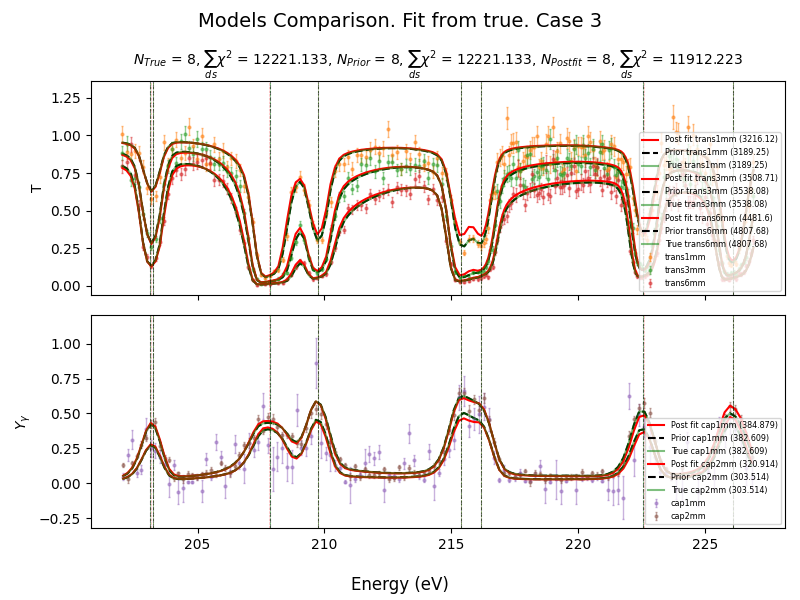

In [12]:
# plot the fit result for this case

fig = elim_addit_funcs.plot_datafits(sample_datasets, sample_experiments, 
        fits=sammyOUT_YW.pw_post, fits_chi2=sammyOUT_YW.chi2_post, f_model_name=f'Post fit', f_color='red',
        priors=sammyOUT_YW.pw, priors_chi2=sammyOUT_YW.chi2, pr_model_name=f'Prior', pr_color='black',

        true=sammyOUT_YW.pw, true_chi2 = sammyOUT_YW.chi2, t_model_name ='True', t_color='green',
            true_pars = sammyOUT_YW.par,
            fit_pars = sammyOUT_YW.par_post, 
            prior_pars = sammyOUT_YW.par,

        title = f'Models Comparison. Fit from true. Case {case_id}',
        show_spingroups = False,
        fig_size = fig_size_data
        )

In [ ]:
cols_to_show = ['E', 'Gg', 'Gn1']
result = elim_addit_funcs.create_comparison_dataframe(sammyOUT_YW, cols_to_show)
result

In [ ]:
# number of points in the datasets

dataset_size = []

for i in cases_ids:
    # get sample data
    sample_id = i
    print(f'Sample id = {sample_id}')
    case_filename = f'sample_{sample_id}.pkl'

    sample_data = elim_addit_funcs.load_obj_from_pkl(folder_name = cases_folder_name,
                                                        pkl_fname = case_filename )

    params_loaded = elim_addit_funcs.load_obj_from_pkl(folder_name = cases_folder_name,
                                                        pkl_fname = gen_params_filename)

    # dataset size
    # dataset size
    sum_points = 0 
    print(f'Dataset sizes: {len(sample_data)}')

    for index,el in enumerate(sample_data):
        print(index, el, sample_data[el].pw_reduced.shape[0])
        sum_points+=sample_data[el].pw_reduced.shape[0]
        
    print(f'Num of points: {sum_points}')
    
    dataset_size.append(sum_points)
    
# end number of points in the datasets

In [ ]:
fig_hist_ds = elim_addit_funcs.plot_multiple_hist(values_list = [dataset_size], 
                        bins = 100, 
                        cumulative= False, 
                        colors = ['r', 'g'], 
                        captions = ['DS', 'Est SFT'], 
                        title = 'Distr of dataset size in generated data ',
                        show_kde = False,
                        stacked = False,
                        show_numbers = False)

***Fit all cases in the provided folder starting from true***

In [ ]:
importlib.reload(elim_addit_funcs)

result_diff_df = pd.DataFrame()

all_true_ladders_df = pd.DataFrame()
all_est_ladders_df = pd.DataFrame()

# N_samples = 10
# for i in range(0, N_samples):

for i in cases_ids:
#for i in range(0,10):
    # get sample data
    sample_id = i
    print(f'Sample id = {sample_id}')
    case_filename = f'sample_{sample_id}.pkl'

    sample_data = elim_addit_funcs.load_obj_from_pkl(folder_name = cases_folder_name,
                                                        pkl_fname = case_filename )

    params_loaded = elim_addit_funcs.load_obj_from_pkl(folder_name = cases_folder_name,
                                                        pkl_fname = gen_params_filename)
    
    #Ta_pair
    syndat_loaded = params_loaded
    Ta_pair_loaded = syndat_loaded.particle_pair

    #print(Ta_pair_loaded.spin_groups)

    # energy range
    print(f'energy range extracted from model: {syndat_loaded.syndat_models[0].generative_experimental_model.energy_range}')
    print(f'Energy rane in Ta_pair: {Ta_pair_loaded.total_energy_range}')

    # combining all the data into appropriate list
    sample_datasets = []
    sample_experiments = []
    sample_covariance_data = []

    for index, el in enumerate(syndat_loaded.syndat_models):

        current_key = list(sample_data)[index] 

        #print('Loading datasets...')
        # print(index)
        # print(el.title)
        #print(current_key)
        #print(type(el.generative_experimental_model))
        #print(el.generative_experimental_model)

        sample_datasets.append(sample_data[current_key].pw_reduced)
        sample_experiments.append(el.generative_experimental_model)
        sample_covariance_data.append(sample_data[current_key].covariance_data)

    
    ig_ladder = sample_data[current_key].par_true.copy()
    ig_ladder = elim_addit_funcs.make_ladder_correct_types(ladder_df=ig_ladder)
    ig_ladder = elim_addit_funcs.set_varying_fixed_params(ladder_df=ig_ladder,
                                                        vary_list=[1,1,1])

    # enrich dataframe with the u-params
    ig_ladder = elim_addit_funcs.update_u_by_p(ladder_full = ig_ladder, 
                                                Ta_pair = Ta_pair_loaded)
    ig_ladder['case_id'] = i

    fit_rto = sammy_classes.SammyRunTimeOptions(
        sammyexe = settings['path_to_SAMMY_exe'],
        options = {"Print"   :   True,
                    "bayes"   :   True,
                    "keep_runDIR"     : False,
                    "sammy_runDIR": elim_addit_funcs.generate_sammy_rundir_uniq_name(path_to_sammy_temps = settings['path_to_SAMMY_temps'])
                    })

    fit_sammyINPyw = sammy_classes.SammyInputDataYW(
        particle_pair = Ta_pair_loaded,
        resonance_ladder = ig_ladder,

        datasets = sample_datasets,
        experiments = sample_experiments,
        experimental_covariance = sample_covariance_data,
            
        max_steps = 10,
        iterations = 2,
        step_threshold = 0.01,
        autoelim_threshold = None,

        LS = False,
        LevMar = True,
        LevMarV = 2,
        LevMarVd= 5,
        initial_parameter_uncertainty = 0.1
        )

    sammyOUT_YW = sammy_functions.run_sammy_YW(fit_sammyINPyw, fit_rto)

    # saving fit result to
    elim_addit_funcs.save_obj_as_pkl(folder_name = fit_res_folder,
                                     file_name = f'fit_res_{i}.pkl',
                                     obj = sammyOUT_YW)
    
    result = elim_addit_funcs.create_comparison_dataframe(sammyOUT_YW, cols_to_show)
    result['case_id'] = i

    # add a noise characteristics for each case

    # end add noise characteristics for each case

        
    all_true_ladders_df = pd.concat([all_true_ladders_df, ig_ladder])

    est_ladder_df = sammyOUT_YW.par_post
    est_ladder_df = elim_addit_funcs.make_ladder_correct_types(ladder_df=est_ladder_df)
    # enrich with u - parameters
    est_ladder_df = elim_addit_funcs.update_u_by_p(ladder_full=est_ladder_df, Ta_pair=Ta_pair_loaded)
    est_ladder_df['case_id'] = i

    all_est_ladders_df = pd.concat([all_est_ladders_df, est_ladder_df])
    
    # save in one dataframe
    result_diff_df = pd.concat([result_diff_df, result])

In [ ]:
print(all_true_ladders_df)
print(all_est_ladders_df)

print(result_diff_df)

In [ ]:
# # TODO: testing the distribution of u_n1... and Gn_1
# # if it's normal or not .. it seems it must be chi2 again.

# import scipy.stats as stats

# # dof_true_Gn1_est, scale_est, some_par_est = stats.chi2.fit(result_diff_df['Gn1_1'], floc=0)

# # dof, loc, scale = stats.chi2.fit(normalized_data, floc=0, fscale=avg_reduced_width_square)
# dof_true_Gn1_est, loc, scale_est = stats.chi2.fit(result_diff_df['Gn1_1'], floc=0, fscale=46.5)


# print(f'Estimated dof = {dof_true_Gn1_est}')
# print(f'Estimated loc = {scale_est}')
# print(f'Estimated scale = {scale_est }')


# # Generating a range of x values
# x = np.linspace(stats.chi2.ppf(0.01, dof_true_Gn1_est), stats.chi2.ppf(0.99, dof_true_Gn1_est), 100)

# # Generating the PDF for these x values
# pdf = stats.chi2.pdf(x, dof_true_Gn1_est, scale=scale_est)


In [ ]:
# analysis of differences...

# saving the differences result df
result_diff_df.to_csv(path_or_buf=cases_folder_name+'start_from_true_params_diff.csv')
all_est_ladders_df.to_csv(path_or_buf=cases_folder_name+'all_est_ladders.csv')
all_true_ladders_df.to_csv(path_or_buf=cases_folder_name+'all_true_ladders.csv')

In [ ]:
importlib.reload(elim_addit_funcs)

In [ ]:

result_diff_df = pd.read_csv(cases_folder_name +'start_from_true_params_diff.csv')



# plot the distribution of u_n1 

# for each separate spin group
# stored in Ta_pair

for sg_ID in all_true_ladders_df["J_ID"].unique():

    # looking through Ta_pair to find key
    for key, val in Ta_pair_loaded.spin_groups.items():
        if float(val['J_ID']) == sg_ID:
            sg_key = key
            print(sg_key)
    
    # # filter all data by "J_ID" column... 
    # print(sg[0])
    # print(sg[1])

    filtered_true = all_true_ladders_df[all_true_ladders_df["J_ID"]==sg_ID]
    filtered_est = all_est_ladders_df[all_est_ladders_df["J_ID"]==sg_ID]

    fig_hist_Un1 = elim_addit_funcs.plot_multiple_hist(values_list = [filtered_true['u_n1'], filtered_est['u_n1']], 
                        bins = 500, 
                        cumulative= False, 
                        colors = ['g', 'r'], 
                        captions = ['True', 'Est SFT'], 
                        title = f'Distr of Un_1 {sg_key} -> <Gn> = {Ta_pair_loaded.spin_groups[sg_key]["<Gn>"]} ',
                        show_kde = False,
                        stacked = False,
                        show_numbers = False)



fig_hist_Gn1 = elim_addit_funcs.plot_multiple_hist(values_list = [result_diff_df['Gn1_1'], result_diff_df['Gn1_2']], 
                        bins = 500, 
                        cumulative= False, 
                        colors = ['g', 'r'], 
                        captions = ['True', 'Est SFT'], 
                        title = 'Distr of Gn1 before and after fitting ',
                        show_kde = False,
                        stacked = False,
                        show_numbers = False)

# import matplotlib.pyplot as plt
# #lotting the theoretical chi-squared distribution on top
# plt.plot(x, pdf, 'b-', lw=2, label='Estimated Chi-Squared Distribution')
# plt.legend()

fig_hist_Gg = elim_addit_funcs.plot_multiple_hist(values_list = [result_diff_df['Gg_1'], result_diff_df['Gg_2']], 
                        bins = 200, 
                        cumulative= False, 
                        colors = ['g', 'r'], 
                        captions = ['True', 'Est SFT'], 
                        title = 'Distr of Gg before and after fitting ',
                        show_kde = False,
                        stacked = False,
                        show_numbers = False)

In [ ]:
# getting max and min for Gn1 true and est from the df
import json

print(f"Gn1 generated:")
print(json.dumps(elim_addit_funcs.analyze_max_min(result_diff_df, 'Gn1_1'),
                  indent=4))
print(f"Gn1 est:")

print(json.dumps(elim_addit_funcs.analyze_max_min(result_diff_df, 'Gn1_2'),
                  indent=4))

print(f"Gg generated:")
print(json.dumps(elim_addit_funcs.analyze_max_min(result_diff_df, 'Gg_1'),
                  indent=4))
print(f"Gg est:")
print(json.dumps(elim_addit_funcs.analyze_max_min(result_diff_df, 'Gg_2'),
                  indent=4))

In [ ]:
def get_case_ids_and_counts_of_res_above_percentile(df, columns, thresholds):
    overall_case_ids = set()
    count_cases_per_column = {}  # Number of unique cases per column with values >= threshold
    cases_per_column = {}  # Unique case ids per column

    for index, col in enumerate(columns):
        threshold = thresholds[index]
        print(f'threshold used: {col} -> {threshold}')

        # Filter cases where the column value is above the threshold
        filtered_cases = df[df[col] >= threshold]['case_id']
        unique_ids = set(filtered_cases)

        # Update overall unique case ids
        overall_case_ids.update(unique_ids)

        # Store counts and unique case ids for this column
        count_cases_per_column[col] = len(unique_ids)
        cases_per_column[col] = unique_ids

    return list(overall_case_ids), count_cases_per_column, cases_per_column


Gg_thr = elim_addit_funcs.analyze_max_min(result_diff_df, 'Gg_2')['q_99']
Gn1_thr = elim_addit_funcs.analyze_max_min(result_diff_df, 'Gn1_2')['q_99']

case_ids_above_thr, count_per_column, cases_per_column = get_case_ids_and_counts_of_res_above_percentile(df=result_diff_df, 
                                                   columns=['Gg_2', 'Gn1_2'], 
                                                   thresholds=[Gg_thr, Gn1_thr])

print(f'{len(case_ids_above_thr)} / {len(result_diff_df.case_id.unique())}')
#print(count_per_column)

print(len(case_ids_above_thr))

for column, case_ids in cases_per_column.items():
    print(f"Column: {column} -> {len(case_ids)}")
    print(f"Case IDs: {sorted(case_ids)}\n")

In [ ]:
# noise level with data chi2

key = 'cap1mm' # where we vary the noise level during the generation

SSE_s = []
CoV_s = []
mSNR_s = []
mUP_s = []
uSR_s = []

sum_chi2_priors_s = []
sum_chi2_posteriors_s = []

chi2_dataset_priors_s = []
chi2_dataset_posteriors_s = []

for index, el in enumerate(syndat_loaded.syndat_models):
    #print('Loading datasets...')
    # print(index)
    print(el.title)
    #current_key = list(sample_data)[index]
    if (el.title==key):
        dataset_index = index


for i in cases_ids:

    # get sample data
    sample_id = i

    print()
    print()
    print(f'Case {i}')
    print()

    case_filename = f'sample_{sample_id}.pkl'

    sample_data = elim_addit_funcs.load_obj_from_pkl(folder_name = cases_folder_name,
                                                        pkl_fname = case_filename)
    
    params_loaded = elim_addit_funcs.load_obj_from_pkl(folder_name = cases_folder_name,
                                                        pkl_fname = gen_params_filename)
    
    
    # energy range
    print(f'energy range extracted from model: {params_loaded.syndat_models[0].generative_experimental_model.energy_range}')   


    exp = sample_data[key].pw_reduced.exp
    unc = sample_data[key].pw_reduced.exp_unc

    # energy grid to calc xs on
    energy_grid_2_compare_on = fine_egrid(energy = params_loaded.syndat_models[0].generative_experimental_model.energy_range)
    print(f'Energy_grid len: {len(energy_grid_2_compare_on)}')
    


    # calculating all the noise related parameters
    CoV = elim_addit_funcs.coefficient_of_variation(exp)
    mSNR = elim_addit_funcs.mean_signal_to_noise_ratio(exp, unc)
    mUP = elim_addit_funcs.mean_uncertainty_percentage(exp, unc)
    uSR = elim_addit_funcs.uncertainty_to_signal_ratio(exp, unc)

    # getting the fit results
    sample_fit_res = elim_addit_funcs.load_fit_res(fit_res_folder= fit_res_folder ,
                                                   case_id = i)
    
    #elim_addit_funcs.printout_chi2(sammyOUT=sample_fit_res)
    
    #prior chi2
    sum_chi2_prior = np.sum(sample_fit_res.chi2)
    # posterior chi2
    sum_chi2_post = np.sum(sample_fit_res.chi2_post)

    # for a selected dataset
    chi2_dataset_prior = sample_fit_res.chi2[dataset_index]
    chi2_dataset_post = sample_fit_res.chi2_post[dataset_index]

    # SSE
    df_est, df_theo, resid_matrix, SSE_dict, xs_figure = elim_addit_funcs.calc_all_SSE_gen_XS_plot(
                        est_ladder = sample_fit_res.par_post,
                        theo_ladder = sample_fit_res.par,
                        Ta_pair = Ta_pair_loaded,
                        settings = settings,
                        energy_grid = energy_grid_2_compare_on,
                        reactions_SSE = ['capture', 'elastic'],
                        fig_size = fig_size_SF_xs,
                        calc_fig = False,
                        fig_yscale='linear'
                )

    SSE_val = SSE_dict['SSE_sum_normalized_casewise'][0]
    print(f'SSE_sum_normalized_casewise: {SSE_val}')


    # print(f'Sample id = {sample_id}')
    # print(key)
    # print(f'CoV: {CoV}')
    # print(f'mSNR: {mSNR}') #dB
    # print(f'mUP: {mUP}') # %
    # print(f'uSR: {uSR}')
    # print()

    CoV_s.append(CoV)
    mSNR_s.append(mSNR)
    mUP_s.append(mUP)
    uSR_s.append(uSR)
    sum_chi2_priors_s.append(sum_chi2_prior)
    sum_chi2_posteriors_s.append(sum_chi2_post)
    chi2_dataset_priors_s.append(chi2_dataset_prior)
    chi2_dataset_posteriors_s.append(chi2_dataset_post)
    SSE_s.append(SSE_val)


In [ ]:
print('Results:')
print(f'For all cases {len(CoV_s)}')
print(f'CoV (mean): {np.mean(CoV_s)}')
print(f'SNR (mean): {np.mean(mSNR_s)}')
print(f'Unc Percentage (mean): {np.mean(mUP_s)}')
print(f'uSR (mean): {np.mean(uSR_s)}')
print(f'Sum chi2 (prior, all data): {np.mean(sum_chi2_priors_s)}')
print(f'Sum chi2 (post, all data): {np.mean(sum_chi2_posteriors_s)}')
print(f'chi2 (prior, {key}): {np.mean(chi2_dataset_priors_s)}')
print(f'chi2 (post, {key}): {np.mean(chi2_dataset_posteriors_s)}')
print()
print(f'SSE (mean): {np.mean(SSE_s)}')
print(f'SSE (median): {np.median(SSE_s)}')

In [ ]:
# find bad cases in the meaning of SSE
def indexes_of_n_largest(SSE_s, N):
    # Pair each element with its index
    indexed_SSE_s = list(enumerate(SSE_s))
    
    # Sort the pairs by the element values in descending order
    sorted_SSE_s = sorted(indexed_SSE_s, key=lambda x: x[1], reverse=True)
    
    # Extract the indexes of the first N elements (the N largest)
    indexes = [index for index, value in sorted_SSE_s[:N]]
    
    return indexes

N = 10

largest_N_SSE = indexes_of_n_largest(SSE_s, N)

print('Largest SSE cases ids:')
print(largest_N_SSE)

largest_N_chi2 = indexes_of_n_largest(sum_chi2_posteriors_s, N)
print('Larges chi2 post case ids:')
print(largest_N_chi2)

# SF



***Specific case visualization***

In [ ]:
# by cases analysis
case_to_show = 160

filtered_params = result_diff_df[result_diff_df['case_id']==case_to_show]
filtered_params

In [ ]:
# to plot the result for one specific case
case_fit_results = elim_addit_funcs.load_fit_res(fit_res_folder = fit_res_folder,     
                                case_id = case_to_show)

# data for this case
case_data_dict = elim_addit_funcs.load_case_data(cases_folder_name = cases_folder_name,     
                                case_id = case_to_show)

case_data = case_data_dict['sample_data']
case_params = case_data_dict['params']


case_datasets = []
case_experiments = []
case_covariance_data = []

# combine datasets and models from the readed dicts
for index, el in enumerate(case_params.syndat_models):

    #print(el.title)
    current_key = list(case_data)[index] 

    case_datasets.append(case_data[current_key].pw_reduced)
    case_experiments.append(el.generative_experimental_model)
    case_covariance_data.append(sample_data[current_key].covariance_data)

    case_true_pars = sample_data[current_key].par_true


case_energy_range = case_params.syndat_models[0].generative_experimental_model.energy_range

energy_grid_2_compare_on = fine_egrid(energy = case_params.syndat_models[0].generative_experimental_model.energy_range)

Ta_pair_loaded = case_params.particle_pair

# print chi2 stats
elim_addit_funcs.printout_chi2(sammyOUT = case_fit_results)

# TODO: Why such values of chi2?? starting from true??? SOmething is not right with covariances?
# how to get full cm having such compact repr?


In [ ]:
# plotting the results..

fig = elim_addit_funcs.plot_datafits(datasets = case_datasets, experiments = case_experiments, 
        fits=case_fit_results.pw_post, fits_chi2=case_fit_results .chi2_post, f_model_name=f'Post fit', f_color='red',
        priors=case_fit_results .pw, priors_chi2=case_fit_results .chi2, pr_model_name=f'Prior', pr_color='black',

        true=case_fit_results.pw, true_chi2 = case_fit_results .chi2, t_model_name ='True', t_color='green',
        
            true_pars = case_fit_results.par,
            fit_pars = case_fit_results.par_post, 
            prior_pars = case_fit_results.par,

        title = f'Models Comparison. Fit from true. Case {case_to_show}',
        show_spingroups = False,
        fig_size = fig_size_data
        )

In [ ]:
# show SSE plot for this case
# xs to show

df_est, df_theo, resid_matrix, SSE_dict, xs_figure = elim_addit_funcs.calc_all_SSE_gen_XS_plot(
                        est_ladder = case_fit_results.par_post,
                        theo_ladder = case_fit_results.par,
                        Ta_pair = Ta_pair_loaded,
                        settings = settings,
                        energy_grid = energy_grid_2_compare_on,
                        reactions_SSE = ['capture', 'elastic'],
                        fig_size = fig_size_SF_xs,
                        calc_fig = True,
                        fig_yscale='linear'
                )


In [ ]:

SSE_Gg, SSE_Gn1, SSE_sf_fig = elim_addit_funcs.calc_strength_functions(
        theoretical_df = case_fit_results.par, 
        estimated_df = case_fit_results.par_post, 
        energy_range = case_energy_range, 
        fig_size = fig_size_SF_xs, 
        create_fig = True,
        )

In [ ]:
# fitting this case with autofit

# for autofit
starting_Gn_coeff = 10 # to Gn01
Gn_thr = 0.05

N_res_autofit = 30 # for one spin group
fit_all_spin_groups = True

# utilizing the autofit from initial FB
from ATARI.AutoFit.initial_FB_solve import InitialFB, InitialFBOPT

sammy_rto_fit = sammy_classes.SammyRunTimeOptions(
    sammyexe=settings['path_to_SAMMY_exe'],
                             options = {"Print"   :   True,
                              "bayes"   :   True,
                              "keep_runDIR"     : True,
                              "sammy_runDIR": elim_addit_funcs.generate_sammy_rundir_uniq_name(path_to_sammy_temps=settings['path_to_SAMMY_temps'])
                              })

options = InitialFBOPT(Gn_threshold = Gn_thr,
                       iterations=2,
                       max_steps = 30,
                       step_threshold=0.01,
                       LevMarV0= 0.05,
                       fit_all_spin_groups = fit_all_spin_groups,
                       fit_Gg = True,
                       num_Elam = N_res_autofit,
                       spin_group_keys = ['3.0'],
                       starting_Gn1_multiplier = starting_Gn_coeff,
                       starting_Gg_multiplier = 1.0,
                       external_resonances = False
                       )

autofit_initial = InitialFB(options)


In [ ]:

IFB_start_time = time.time()

outs = autofit_initial.fit(particle_pair = Ta_pair_loaded,
                               energy_range = case_energy_range,
                               datasets = case_datasets,
                               experiments = case_experiments,
                               covariance_data = case_covariance_data,
                               sammyRTO = sammy_rto_fit,
                               external_resonance_ladder = pd.DataFrame() #sel_jeff_side_res_df
                               )

IFB_end_time = time.time()

print(f'Fitting from IFB took: {elim_addit_funcs.format_time_2_str(IFB_end_time - IFB_start_time)[1]}')
N_initial_FB = outs.final_internal_resonances.shape[0]

print(f'Final result, internal res., number of res: {N_initial_FB}')

In [ ]:

elim_addit_funcs.printout_chi2(outs.sammy_outs_fit_1[0], 'autofit prior')
elim_addit_funcs.printout_chi2(outs.sammy_outs_fit_2[-1], 'autofit posterior')

print('Full Final ladder after autofit')
print(outs.final_resonace_ladder)

# print('Posterior parameters:')
# print(outs.sammy_outs_fit_2[-1].par_post)

print('External resonances:')
print(outs.final_external_resonances)

print('Internal resonances:')
print(outs.final_internal_resonances)

# final fit result
final_fb_output = outs.sammy_outs_fit_2[-1]

In [ ]:

# plotting to show pos. of resonances
fig2 = elim_addit_funcs.plot_datafits(
    case_datasets, 
    case_experiments, 
    
    fits = final_fb_output.pw_post, 
    fits_chi2 = final_fb_output.chi2_post, 
    f_model_name = 'AF post',
    f_color = 'red',
    
    priors = outs.sammy_outs_fit_1[0].pw, 
    priors_chi2 = outs.sammy_outs_fit_1[0].chi2, 
    pr_model_name='AF prior',
    pr_color = 'orange',

        true=case_fit_results.pw, 
        true_chi2 = case_fit_results .chi2, 
        t_model_name ='True', 
        t_color='green',

    true_pars = case_fit_results.par,
    fit_pars = final_fb_output.par_post,
    prior_pars = final_fb_output.par,
      
    title = 'Models Comparison. Autofit result',
    show_spingroups = False,
    fig_size = fig_size_data
)

In [ ]:
# xs to show

df_est, df_theo, resid_matrix, SSE_dict, xs_figure = elim_addit_funcs.calc_all_SSE_gen_XS_plot(
                        est_ladder = final_fb_output.par_post,
                        theo_ladder = case_fit_results.par,
                        Ta_pair = Ta_pair_loaded,
                        settings = settings,
                        energy_grid = energy_grid_2_compare_on,
                        reactions_SSE = ['capture', 'elastic'],
                        fig_size = fig_size_SF_xs,
                        calc_fig = True,
                        fig_yscale='linear'
                        )

In [ ]:
SSE_Gg, SSE_Gn1, SSE_sf_fig = elim_addit_funcs.calc_strength_functions(
        theoretical_df = case_fit_results.par, 
        estimated_df = final_fb_output.par_post, 
        energy_range = case_energy_range, 
        fig_size = fig_size_SF_xs, 
        create_fig = True,
        )